##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1455881`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [798]:
import numpy as np
import pandas as pd


In [799]:
# read the input file
df = pd.read_csv("sms_supervised_train.csv")

print(df.head())

                                        textOriginal  \
0                       So u workin overtime nigpun?   
1  Also sir, i sent you an email about how to log...   
2  Ok lor. Anyway i thk we cant get tickets now c...   
3                                 Wat r u doing now?   
4  Is there a reason we've not spoken this year? ...   

                                    textPreprocessed  class  
0                                         ? u workin      0  
1  . . .. sir , send send email log payment ll an...      0  
2  ? . . 2 4 u quite get ok lor anyway thk ticket...      0  
3                                          ? u wat r      0  
4   ? great reason speak year anyways week good exam      0  


In [800]:
def create_vocabulary(data):
    words = " ".join(data['textPreprocessed'].fillna('').astype(str)).split()
    vocabulary, _ = np.unique(words, return_counts=True)
    vocabulary = list(vocabulary)
    return vocabulary

In [801]:
def create_count(data, vocab):
    N = len(data)
    V = len(vocab)
    count= np.zeros((N, V), dtype=int)
    total = 0

    for i, text in enumerate(data['textPreprocessed'].fillna('').astype(str)):
        for word in text.split():
            if word in vocab:
                j = vocab.index(word)
                count[i, j] += 1
                total += 1
    
    return count

In [802]:
# Probability of all the labels
def calc_prior(df):
    class_counts = df['class_label'].value_counts()
    N = len(df)
    priors = {}
    for c, count in class_counts.items():
        priors[c] = count / N
    return priors


In [803]:
def word_likelihood_with_smoothing(data):
    # Create an empty dictionary to store the likelihoods
    word = {}
    labels = data['class_label']
    unique_labels = np.unique(labels)
    features_list = [col for col in data.columns if col != 'class_label']
    total_sum = 0
    alpha = 1

    for feature in features_list:
        # feature_values = np.unique(data[feature])
        
        # Create a nested dictionary for each feature
        word[feature] = {}

        for label in unique_labels:
            # Create a nested dictionary for each label
            word[feature][label] = {}

            count = data[(data["class_label"] == label)][feature].sum()
            #print(count)
            total_count = data[data["class_label"] == label][features_list].sum(axis=1).sum()
            #print(total_count)

            # laplace smoothing
            total_count += alpha*len(features_list)
            count += alpha

            word[feature][label] = count / total_count
            total_sum += count / total_count
            #print(f"Likelihood of {feature} given label {label} is {word[feature][label]:.4f}")
            #print(f"Likelihood of {feature}={value} given label {label} is {likelihood[feature][label][value]:.4f}")
    #print(total_sum)
    return word

In [804]:
def create_matrix (data):
    vocabulary = create_vocabulary(data)
    count_df = pd.DataFrame(create_count(data, vocabulary), columns=vocabulary)

    try:
        if "class_label" in vocabulary:
            raise ValueError("The column name 'class_label' is already in use in the vocabulary. Please use a different name for the class column.")
        count_df['class_label'] = df['class']
    except ValueError as e:
        print(e)

    return vocabulary, count_df

In [805]:
# the function to train original dataframe at once
def train_model(count_df):

    # Calculate prior probabilities
    prior_prob = calc_prior(count_df)

    # Calculate likelihoods
    likelihood = word_likelihood_with_smoothing(count_df)

    return prior_prob, likelihood

In [806]:
# train the model
vocabulary, count_df = create_matrix(df)
priors_prob, word_probs = train_model(count_df)

print("Priors:", priors_prob)
print("likelihood:", word_probs)

Priors: {0: 0.8, 1: 0.2}
likelihood: {'!': {0: 0.017187325047587056, 1: 0.024350472877486682}, '"': {0: 0.005598477214197738, 1: 0.0007609522774214588}, '#': {0: 0.0053745381256298285, 1: 0.0006522448092183933}, '$': {0: 0.00044787817713581906, 1: 0.0007609522774214588}, '%': {0: 0.00016795431642593214, 1: 0.0008696597456245244}, '&': {0: 0.013100436681222707, 1: 0.008696597456245243}, "'": {0: 0.003918934049938417, 1: 0.0011957821502337211}, "'ll": {0: 0.0006158324935617512, 1: 0.00010870746820306555}, "'m": {0: 0.00011196954428395476, 1: 0.00010870746820306555}, "'re": {0: 0.0003359086328518643, 1: 0.00010870746820306555}, "'s": {0: 0.0052065838092038965, 1: 0.0018480269594521143}, "'ve": {0: 5.598477214197738e-05, 1: 0.00097836721382759}, '(': {0: 0.000727802037845706, 1: 0.00391346885531036}, ')': {0: 0.0013436345314074571, 1: 0.00391346885531036}, '*': {0: 0.0030231776956667787, 1: 0.007065985433199261}, '+': {0: 0.0005598477214197738, 1: 0.004022176323513425}, ',': {0: 0.02603291

In [807]:
class_words = {}

# Initialize dictionary for each class
for word, probs in word_probs.items():
    for label, prob in probs.items():
        if label not in class_words:
            class_words[label] = []
        class_words[label].append((word, prob))

# Sort and print top N words for each class
for label in sorted(class_words.keys()):
    print(f"\nTop {10} words for class {label}:")
    sorted_words = sorted(class_words[label], key=lambda x: x[1], reverse=True)
    for word, prob in sorted_words[:10]:
        print(f"{word}: {prob:.6f}")


Top 10 words for class 0:
.: 0.079330
,: 0.026033
?: 0.025585
u: 0.018923
...: 0.018755
!: 0.017187
..: 0.014948
;: 0.013156
&: 0.013100
go: 0.011141

Top 10 words for class 1:
.: 0.056528
!: 0.024350
,: 0.023481
call: 0.020546
£: 0.013915
free: 0.010545
/: 0.009131
2: 0.008805
&: 0.008697
?: 0.008479


In [808]:
ratios = []

for word, probs in word_probs.items():
    p0 = probs.get(0, 1e-10)  # Avoid division by zero
    p1 = probs.get(1, 1e-10)
    ratio = p1 / p0
    ratios.append((word, ratio))

# Top predictors for class 1 (scam): Highest R values
print(f"\nTop {10} most predictive words for SCAM class (class 1):")
top_scams = sorted(ratios, key=lambda x: x[1], reverse=True)[:10]
for word, r in top_scams:
    print(f"{word}: R = {r:.4f}")

# Top predictors for class 0 (non-malicious): Lowest R values
print(f"\nTop {10} most predictive words for NON-MALICIOUS class (class 0):")
top_non_malicious = sorted(ratios, key=lambda x: x[1])[:10]
for word, r in top_non_malicious:
    print(f"{word}: R = {r:.4f}")


Top 10 most predictive words for SCAM class (class 1):
prize: R = 99.0284
tone: R = 64.0772
£: R = 49.7084
select: R = 46.6016
claim: R = 45.9543
paytm: R = 36.8929
code: R = 34.9512
award: R = 32.0386
won: R = 31.0677
18: R = 29.1260

Top 10 most predictive words for NON-MALICIOUS class (class 0):
;: R = 0.0165
...: R = 0.0174
gt: R = 0.0185
lt: R = 0.0187
:): R = 0.0209
ü: R = 0.0313
lor: R = 0.0347
hope: R = 0.0405
ok: R = 0.0405
d: R = 0.0474


In [809]:
import math
from math import factorial, log
from functools import reduce

def calc_posterior_with_smoothing(data, prior_prob, word_probs, alpha=1.0):
    posterior_probs = []
    classes = prior_prob.keys()

    for _, instance in data.iterrows():
        x_vector = instance.to_dict()
        n = sum(x_vector.values())  # total number of words in the row
 
        # Precompute factorials for multinomial coefficient
        # try:
        #numerator = factorial(n)
        #denominator = reduce(lambda a, b: a * b, [factorial(x) for x in x_vector.values() if x > 0], 1)
        #multinomial_coeff = numerator / denominator
        # Optional: Log multinomial coefficient

        log_multinomial_coeff = math.lgamma(n + 1) - sum(
            math.lgamma(x + 1) for x in x_vector.values() if x > 0
        ) # applying gamma function math.lgamma(n + 1) gives you log(factorial(n)) without computing the factorial directly

        # except OverflowError:
            # If n is too large, we can safely omit multinomial coefficient (constant across classes)
            # multinomial_coeff = 1.0

        post_probs = {}

        for label in classes:
            log_prob = math.log(prior_prob[label]) + log_multinomial_coeff
            #prob = prior_prob[label] * multinomial_coeff

            for word, x_i in x_vector.items():
                if x_i == 0:
                    continue

                # Get smoothed P(word | class)
                p_c_i = word_probs.get(word, {}).get(label, None)
                if p_c_i is None:
                    # If somehow missing, apply Laplace smoothing manually
                    V = len(word_probs)
                    p_c_i = alpha / (alpha * V)
                    # print the misssing value:
                    #print("mission value with smoothing:", word)

                #print("word:", word)
                #print("pci:",p_c_i)
                #prob *= p_c_i ** x_i
                log_prob += x_i * math.log(p_c_i)

            post_probs[label] = log_prob

        # Normalize
        #total = sum(post_probs.values())
        #if total == 0:
            #norm_probs = {label: 1.0 / len(classes) for label in classes}
        #else:
            #norm_probs = {label: post_probs[label] / total for label in classes}

        posterior_probs.append(post_probs)

    return posterior_probs

In [810]:
# posterior_prob testing 
#posterior_probs = calc_posterior_with_smoothing(test_count, priors_prob, word_probs)
#print(posterior_probs)

In [811]:
def predict_test_with_smoothing(data, prior_prob, likelihood):
    # Calculate posterior log-probabilities
    posterior_probs = calc_posterior_with_smoothing(data, prior_prob, likelihood)

    # Find the class with the highest log-probability
    # Use Python built-in max() to find the label with the highest log-probability
    argmax_labels = [max(post, key=post.get) for post in posterior_probs]
    return argmax_labels, posterior_probs

## 2. Supervised model evaluation

In [812]:
test_df = pd.read_csv("sms_test.csv")

In [813]:
test_vocabulary = create_vocabulary(test_df)
len(test_vocabulary)

1641

In [814]:
test_count = pd.DataFrame(create_count(test_df, test_vocabulary), columns = test_vocabulary)
test_count

,!,"""",#,$,%,&,','ll,'m,'re,...,yun,yup,zed,|,,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [815]:
predictions, posterior_probs = predict_test_with_smoothing(test_count, priors_prob, word_probs)

In [816]:
from sklearn.metrics import accuracy_score

def calc_accuracy(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    correct = int(accuracy * len(true_labels))
    total = len(true_labels)
    
    print("correct predict:", correct)
    print("total test:", total)
    return accuracy

In [817]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(predictions, true_labels)
print("Accuracy:", accuracy)

correct predict: 975
total test: 1000
Accuracy: 0.975


In [818]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

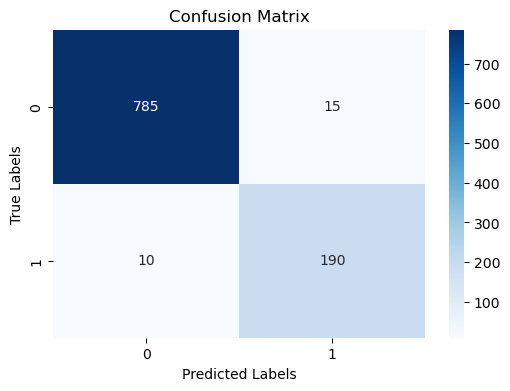


Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9812    0.9843       800
           1     0.9268    0.9500    0.9383       200

    accuracy                         0.9750      1000
   macro avg     0.9571    0.9656    0.9613      1000
weighted avg     0.9753    0.9750    0.9751      1000



In [819]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, predictions, digits=4))

In [820]:
# out-of-vocabulary words in the test set
def new_vocab(vocab1, vocab2):
    new_words = set(vocab1) - set(vocab2)
    if new_words:
        print("New words not in training vocabulary:")
        print(new_words)
        print("Number of new words:")
        print(len(new_words))
    else:
        print("All test vocabulary words are present in the training vocabulary.")


In [821]:
new_vocab(test_vocabulary, vocabulary)

New words not in training vocabulary:
{'possession', 'title', 'bet', 'infernal', 'esplanade', 'fromm', 'trouble', 'skype', '://', 'activity', 'pg', '0845', 'armand', 'realise', 'ru', '81151', 'dreams', 't-mobile', 'law', 'piece', 'boston', 'ec2a', 'oz', 'daddy', 'empty', 'lecture', 'sup', 'definitely', 'feelin', '2nite', 'nyc', 'fyi', 'legal', 'annoying', 'prabha', 'postcode', 'require', 'aiyar', 'realy', '87131', 'market', '=d', 'girlfrnd', 'gram', 'grl', 'mini', '32', 'fee', 'dick', 'holla', 'nearly', 'pie', 'fetch', 'fault', 'manage', 'pack', 'report', '0578', 'asleep', 'calling', 'journey', 'rally', 'hmv', 'ta', 'cancer', 'k.', '6hrs', 'inside', 'experience', 'harry', 'wed', 'greet', 'sen', 'woke', 'depend', '7250i', 'yijue', 'hook', 'drivin', 'befor', 'exactly', 'lay', 'lift', 'yahoo', 'lmao', 'din', 'affair', '1956669', 'challenge', 'plot', 'wet', 'act', 'fire', 'bud'}
Number of new words:
94


In [893]:
def predict_confidence(test_df, posterior_probs, prediction, class1=0, class2=1):
    results = []

    for i, post_probs in enumerate(posterior_probs):
        log_prob_c0 = post_probs[class1]
        log_prob_c1 = post_probs[class2]

        # Convert log probs to actual probs via softmax normalization (optional but more accurate)
        max_log = max(log_prob_c0, log_prob_c1)
        prob_c0 = math.exp(log_prob_c0 - max_log)
        prob_c1 = math.exp(log_prob_c1 - max_log)
        total = prob_c0 + prob_c1
        norm_prob_c0 = prob_c0 / total
        norm_prob_c1 = prob_c1 / total

        R = norm_prob_c1 / norm_prob_c0  # scam / non-malicious
        predicted_class = prediction[i]
        actual_class = test_df.iloc[i]['class'] if 'class' in test_df.columns else None
        original_text = test_df.iloc[i]['textPreprocessed'] if 'textPreprocessed' in test_df.columns else None

        results.append({
            'textPreprocessed': original_text,
            'predicted_class': predicted_class,
            'actual_class': actual_class,
            #f'{class1}_prob': round(norm_prob_c0, 6),
            #f'{class2}_prob': round(norm_prob_c1, 6),
            f'{class1}_prob': norm_prob_c0,
            f'{class2}_prob': norm_prob_c1,
            #'R': round(R, 4)
            'R': R
        })

    # Convert to DataFrame if it's a list of dicts
    if isinstance(results, list):
        result_df = pd.DataFrame(results)


    return result_df

In [924]:
results_df = predict_confidence(test_df, posterior_probs, predictions)

In [925]:
def show_confidence_examples(result_df, class0='0', class1='1'):
    result_df = result_df.copy()
    
    # Ensure consistent string types
    result_df['predicted_class'] = result_df['predicted_class'].astype(str)
    result_df['actual_class'] = result_df['actual_class'].astype(str)

    # Compute distance from R = 1
    result_df['R_diff_from_1'] = (result_df['R'] - 1).abs()

    # Get top examples by confidence
    high_conf_class1 = result_df[result_df['predicted_class'] == class1].sort_values('R', ascending=False)
    high_conf_class0 = result_df[result_df['predicted_class'] == class0].sort_values('R', ascending=True)
    near_boundary = result_df.sort_values('R_diff_from_1')

    # Drop helper column
    high_conf_class1.drop(columns=['R_diff_from_1'], inplace=True)
    high_conf_class0.drop(columns=['R_diff_from_1'], inplace=True)
    near_boundary.drop(columns=['R_diff_from_1'], inplace=True)

    # Return the three subsets
    return high_conf_class1, high_conf_class0, near_boundary

In [926]:
# Then get top examples as dataframes
high_conf_class1_df, high_conf_class0_df, boundary_df = show_confidence_examples(results_df)

# Save to CSV if needed:
# high_conf_class1_df.to_csv("high_conf_class1.csv", index=False)

In [927]:
high_conf_class1_df.head(3)

,textPreprocessed,predicted_class,actual_class,0_prob,1_prob,R
844,. 4 + call £ - * holiday & urgent 18 t landlin...,1,1,7.426503e-21,1.0,1.346529e+20
985,. 3 4 + ! call : £ offer * holiday & urgent 18...,1,1,7.815483e-21,1.0,1.279511e+20
460,". . . , please order text call / : customer to...",1,1,8.763776e-21,1.0,1.141061e+20


In [928]:
high_conf_class0_df.head(3)

,textPreprocessed,predicted_class,actual_class,0_prob,1_prob,R
341,time : rs. transaction number & & & & & & & & ...,0,0,1.0,1.084297e-38,1.084297e-38
223,"? ? ? ? .. .. u u u u , , ... ... ... ... say ...",0,0,1.0,3.670796e-30,3.670796e-30
969,. every & & & & & & ; ; ; ; ; ; lt lt lt # # #...,0,0,1.0,3.123974e-26,3.123974e-26


In [929]:
boundary_df.head(3)

,textPreprocessed,predicted_class,actual_class,0_prob,1_prob,R
90,. call dear,0,0,0.504409,0.495591,0.982520
455,. reply glad,0,0,0.510960,0.489040,0.957099
767,. . tell return re order,1,0,0.482143,0.517857,1.074075


## 3. Extending the model with semi-supervised training

##### Read unlabelled csv file

In [830]:
unlabel_df = pd.read_csv("sms_unlabelled.csv")
unlabel_vocabulary = create_vocabulary(unlabel_df)
len(unlabel_vocabulary)

1983

In [831]:
new_vocab(unlabel_vocabulary, vocabulary)

New words not in training vocabulary:
{'agree', 'taunton', 'possession', 'title', 'bet', 'peace', 'brain', 'infernal', 'esplanade', 'fromm', 'trouble', 'skype', '://', 'activity', 'pg', '0845', 'armand', 'realise', 'hun', 'stick', 'ru', '81151', 'roger', 'nichols', 'sura', 't-mobile', 'law', 'piece', 'bahamas', 'boston', 'ec2a', 'daddy', 'empty', 'lecture', 'sup', 'definitely', 'feelin', '2nite', 'nyc', 'fyi', 'legal', 'annoying', 'prabha', 'cruise', 'postcode', 'require', 'aiyar', 'proof', 'realy', 'santa', 'should', '87131', 'market', '=d', 'girlfrnd', 'gram', 'mini', '32', 'fee', 'body', 'pull', 'dick', 'holla', 'sha', 'nearly', 'é', 'bloody', 'pie', 'skilgme', 'fetch', 'fault', 'skip', 'insurance', 'clock', 'manage', 'pack', '88039', 'report', '0578', 'asleep', 'calling', 'journey', 'hmv', 'ta', 'cancer', 'k.', 'callfreefone', '5min', 'inside', 'experience', 'harry', 'wed', 'greet', 'sen', 'woke', 'depend', '7250i', 'basic', 'yijue', 'hook', 'ma', 'befor', '08081560665', 'august', 

##### Baseline model using ramdom sampling for the 200 instances

In [880]:
# baseline: random sampling 
# Randomly sample from unlabelled data
sampled = unlabel_df.sample(n=200, random_state=42)
baseline_train_data = pd.concat([df, sampled], axis=0)

baseline_train_data

,textOriginal,textPreprocessed,class
0,So u workin overtime nigpun?,? u workin,0
1,"Also sir, i sent you an email about how to log...",". . .. sir , send send email log payment ll an...",0
2,Ok lor. Anyway i thk we cant get tickets now c...,? . . 2 4 u quite get ok lor anyway thk ticket...,0
3,Wat r u doing now?,? u wat r,0
4,Is there a reason we've not spoken this year? ...,? great reason speak year anyways week good exam,0
...,...,...,...
462,Play w computer? Aiyah i tok 2 u lor?,? ? 2 u lor computer aiyah play w,0
1105,Todays Vodafone numbers ending 7148 are select...,. please call award apply end rs. vodafone tod...,1
855,"chile, please! It's only a &lt;DECIMAL&gt; h...",". . come , please ! time & & ; ; hour lt gt dr...",0
693,Send me your id and password,send id password,0


In [881]:
semi_vocabulary = create_vocabulary(baseline_train_data)
len(semi_vocabulary)

2035

In [882]:
semi_count = pd.DataFrame(create_count(baseline_train_data, semi_vocabulary), columns = semi_vocabulary)
semi_count

,!,"""",#,$,%,&,','ll,'m,'re,...,yup,zed,|,,¡,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2197,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [883]:
# train the new semi-supervised model
base_vocabulary, baseline_df = create_matrix(baseline_train_data)
base_priors_prob, base_word_probs = train_model(baseline_df)

print("Baseline Priors:", base_priors_prob)
print("Baseline likelihood:", base_word_probs)

Baseline Priors: {0.0: 0.7272727272727273, 1.0: 0.18181818181818182}
Baseline likelihood: {'!': {0.0: 0.01715946565312168, 1.0: 0.024273948851322065, nan: 0.0004914004914004914}, '"': {0.0: 0.005589402492873512, 1.0: 0.0007585609016038145, nan: 0.0004914004914004914}, '#': {0.0: 0.005365826393158571, 1.0: 0.0006501950585175553, nan: 0.0004914004914004914}, '$': {0.0: 0.00044715219942988095, 1.0: 0.0007585609016038145, nan: 0.0004914004914004914}, '%': {0.0: 0.00016768207478620536, 1.0: 0.0008669267446900737, nan: 0.0004914004914004914}, '&': {0.0: 0.013079201833324018, 1.0: 0.008669267446900737, nan: 0.0004914004914004914}, "'": {0.0: 0.003912581745011458, 1.0: 0.0011920242739488513, nan: 0.0004914004914004914}, "'ll": {0.0: 0.0006148342742160863, 1.0: 0.00010836584308625921, nan: 0.0004914004914004914}, "'m": {0.0: 0.00011178804985747024, 1.0: 0.00010836584308625921, nan: 0.0004914004914004914}, "'re": {0.0: 0.0003353641495724107, 1.0: 0.00010836584308625921, nan: 0.000491400491400491

##### Second Strategy: Uncertainty Sampling, Pick high-entropy samples

In [836]:
# entropy computation
from scipy.stats import entropy

def compute_entropy_scores(unlabelled_data, posterior_function, prior, likelihood):
    
    select_posterior_probs = posterior_function(unlabelled_data, prior, likelihood)

    entropy_values = []
    for probs in select_posterior_probs:
        log_prob_c0 = probs[0]
        log_prob_c1 = probs[1]

        # Convert log probs to actual probs via softmax normalization (optional but more accurate)
        max_log = max(log_prob_c0, log_prob_c1)
        prob_c0 = math.exp(log_prob_c0 - max_log)
        prob_c1 = math.exp(log_prob_c1 - max_log)
        total = prob_c0 + prob_c1
        norm_prob_c0 = prob_c0 / total
        norm_prob_c1 = prob_c1 / total
        norm_prob = {0: norm_prob_c0, 1: norm_prob_c1}
        
        entropy_val = entropy(list(norm_prob.values()), base=2)
        entropy_values.append(entropy_val)


    return pd.Series(entropy_values, index=unlabelled_data.index)

In [862]:
def select_high_entropy_samples(unlabelled_data, entropy_scores, k=200):
    top_k_indices = entropy_scores.sort_values(ascending=False).head(k).index
    selected_df = unlabelled_data.loc[top_k_indices]
    return selected_df

In [902]:
unlabel_count = pd.DataFrame(create_count(unlabel_df, unlabel_vocabulary), columns = unlabel_vocabulary)

# Step 1: Compute entropy
entropy_scores = compute_entropy_scores(unlabel_count, calc_posterior_with_smoothing, priors_prob, word_probs)

# Step 2: Select top-k high-entropy samples
selected_entropy = select_high_entropy_samples(unlabel_count, entropy_scores, k=200)

In [903]:
selected_entropy

,!,"""",#,$,%,&,','ll,'re,'s,...,zed,|,,¡,£,é,ü,–,…,�
929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [879]:
entropy_train_data = pd.concat([count_df,selected_entropy])

# Replace all NaN values with 0
entropy_train_data = entropy_train_data.fillna(0)
entropy_train_data = entropy_train_data.astype(int)
entropy_train_data = entropy_train_data.loc[:, (entropy_train_data != 0).any(axis=0)]

entropy_train_data


,!,"""",#,$,%,&,','ll,'m,'re,...,experience,fyi,lecture,lmao,pie,piece,possession,proof,realise,santa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1292,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [868]:
# train the new semi-supervised model
#entropy_vocabulary, entropy_df = create_matrix(df)
entropy_priors_prob, entropy_word_probs = train_model(entropy_train_data)

print("Entropy Priors:", entropy_priors_prob)
print("Entropy likelihood:", entropy_word_probs)

Entropy Priors: {0: 0.8181818181818182, 1: 0.18181818181818182}
Entropy likelihood: {'!': {0: 0.01787874007467003, 1: 0.024313470096602625}, '"': {0: 0.005416206552032392, 1: 0.000759795940518832}, '#': {0: 0.005048114844612715, 1: 0.0006512536633018561}, '$': {0: 0.0004206762370510596, 1: 0.000759795940518832}, '%': {0: 0.0002103381185255298, 1: 0.0008683382177358081}, '&': {0: 0.012620287111531788, 1: 0.008683382177358081}, "'": {0: 0.003891255192722301, 1: 0.0011939650493867362}, "'ll": {0: 0.000578429825945207, 1: 0.00010854227721697601}, "'m": {0: 0.0001051690592627649, 1: 0.00010854227721697601}, "'re": {0: 0.0003155071777882947, 1: 0.00010854227721697601}, "'s": {0: 0.005100699374244098, 1: 0.0018452187126885922}, "'ve": {0: 0.00015775358889414735, 1: 0.0009768804949527841}, '(': {0: 0.0008413524741021192, 1: 0.0039075219798111365}, ')': {0: 0.001419782300047326, 1: 0.0039075219798111365}, '*': {0: 0.003260240837145712, 1: 0.007055248019103441}, '+': {0: 0.0007361834148393542, 1

In [869]:
len(entropy_train_data.columns)

2021

##### R confidence selection

In [963]:
unlabel_predictions, unlabel_posterior_probs = predict_test_with_smoothing(unlabel_count, priors_prob, word_probs)

In [964]:
unlabel_confidence_df = predict_confidence(unlabel_df, unlabel_posterior_probs, unlabel_predictions)

In [965]:
_,_, unlabel_boundary_df = show_confidence_examples(unlabel_confidence_df)


In [969]:
unlabel_boundary_df.head(200)

,textPreprocessed,predicted_class,class,0_prob,1_prob,R
929,. country stamp,1,0,0.498139,0.501861,1.007472
349,:) win win big luck,0,0,0.509874,0.490126,0.961270
1495,win next number wot wine money,0,1,0.514016,0.485984,0.945464
942,please,0,0,0.516820,0.483180,0.934908
189,reply free free message get go right ! : just ...,1,1,0.483087,0.516913,1.070019
...,...,...,...,...,...,...
344,. wife,0,0,0.962989,0.037011,0.038433
768,. late call ill film,0,0,0.963275,0.036725,0.038125
1611,. . . 2 .. buy urgent car wnt arrange vry urge...,0,0,0.963800,0.036200,0.037560
511,yup,0,0,0.964003,0.035997,0.037341


In [968]:
unlabel_boundary_df.rename(columns={'actual_class': 'class'}, inplace=True)
unlabel_boundary_df[['textPreprocessed','class']].head(200)

,textPreprocessed,class
929,. country stamp,0
349,:) win win big luck,0
1495,win next number wot wine money,1
942,please,0
189,reply free free message get go right ! : just ...,1
...,...,...
344,. wife,0
768,. late call ill film,0
1611,. . . 2 .. buy urgent car wnt arrange vry urge...,0
511,yup,0


In [944]:
unlabel_boundary_df.rename(columns={'actual_class': 'class'}, inplace=True)
confidence_train_df = pd.concat([df[['textPreprocessed','class']],unlabel_boundary_df[['textPreprocessed','class']].head(200)])


In [945]:
confidence_train_df

,textPreprocessed,class
0,? u workin,0
1,". . .. sir , send send email log payment ll an...",0
2,? . . 2 4 u quite get ok lor anyway thk ticket...,0
3,? u wat r,0
4,? great reason speak year anyways week good exam,0
...,...,...
344,. wife,0
768,. late call ill film,0
1611,. . . 2 .. buy urgent car wnt arrange vry urge...,0
511,yup,0


In [947]:
confidence_vocabulary, confidence_count = create_matrix(confidence_train_df)
confidence_priors_prob, confidence_word_probs = train_model(confidence_count)

print("Priors:", confidence_priors_prob)
print("likelihood:", confidence_word_probs)

Priors: {0.0: 0.7272727272727273, 1.0: 0.18181818181818182}
likelihood: {'!': {0.0: 0.01717290373105107, 1.0: 0.024310831343607554, nan: 0.0004948045522018803}, '"': {0.0: 0.0055937797169547466, 1.0: 0.000759713479487736, nan: 0.0004948045522018803}, '#': {0.0: 0.005370028528276557, 1.0: 0.0006511829824180595, nan: 0.0004948045522018803}, '$': {0.0: 0.0004475023773563797, 1.0: 0.000759713479487736, nan: 0.0004948045522018803}, '%': {0.0: 0.0001678133915086424, 1.0: 0.0008682439765574126, nan: 0.0004948045522018803}, '&': {0.0: 0.013089444537674107, 1.0: 0.008682439765574127, nan: 0.0004948045522018803}, "'": {0.0: 0.003915645801868322, 1.0: 0.0011938354677664424, nan: 0.0004948045522018803}, "'ll": {0.0: 0.0006153157688650221, 1.0: 0.00010853049706967658, nan: 0.0004948045522018803}, "'m": {0.0: 0.00011187559433909493, 1.0: 0.00010853049706967658, nan: 0.0004948045522018803}, "'re": {0.0: 0.0003356267830172848, 1.0: 0.00010853049706967658, nan: 0.0004948045522018803}, "'s": {0.0: 0.005

## 4. Supervised model evaluation

In [884]:
len(base_vocabulary)

2035

In [960]:
# baseline testing
base_predictions, _ = predict_test_with_smoothing(test_count, base_priors_prob, base_word_probs)

In [886]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(base_predictions, true_labels)
print("Accuracy:", accuracy)

correct predict: 975
total test: 1000
Accuracy: 0.975


In [887]:
new_vocab(test_vocabulary, base_vocabulary)

New words not in training vocabulary:
{'ec2a', 'oz', 'daddy', 'possession', 'pie', 'empty', 'hook', 'lecture', 'drivin', 'sup', 'definitely', 'title', '2nite', 'bet', 'befor', 'infernal', 'legal', 'manage', 'annoying', 'esplanade', 'prabha', 'fromm', 'report', 'pack', 'postcode', '0578', 'require', 'asleep', 'exactly', 'journey', 'lay', 'calling', 'skype', '://', 'yahoo', 'aiyar', 'rally', 'lmao', 'pg', 'activity', 'realy', 'din', 'affair', 'ta', '1956669', 'cancer', 'challenge', '87131', '6hrs', 'armand', 'realise', '=d', 'girlfrnd', 'market', 'plot', 'gram', 'grl', '81151', 'mini', 'dreams', 'wet', 'experience', 'law', 'act', 'harry', 'sen', 'fee', '32', 'dick', '7250i', 'fire', 'bud'}
Number of new words:
72


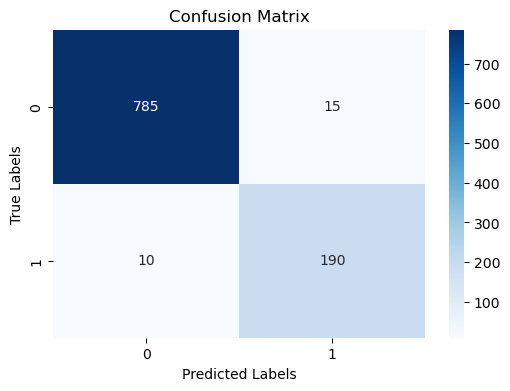


Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9812    0.9843       800
           1     0.9268    0.9500    0.9383       200

    accuracy                         0.9750      1000
   macro avg     0.9571    0.9656    0.9613      1000
weighted avg     0.9753    0.9750    0.9751      1000



In [888]:
# Confusion Matrix
cm = confusion_matrix(true_labels, base_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, base_predictions, digits=4))

In [957]:
# entropy testing
entropy_predictions, _ = predict_test_with_smoothing(test_count, entropy_priors_prob, entropy_word_probs)


In [958]:
true_labels = test_df['class'].tolist()
entropy_accuracy = calc_accuracy(entropy_predictions, true_labels)
print("Accuracy:", entropy_accuracy)

correct predict: 980
total test: 1000
Accuracy: 0.98


In [959]:
new_vocab(test_vocabulary, entropy_vocabulary)

New words not in training vocabulary:
{'possession', 'title', 'bet', 'infernal', 'esplanade', 'fromm', 'trouble', 'skype', '://', 'activity', 'pg', '0845', 'armand', 'realise', 'ru', '81151', 'dreams', 't-mobile', 'law', 'piece', 'boston', 'ec2a', 'oz', 'daddy', 'empty', 'lecture', 'sup', 'definitely', 'feelin', '2nite', 'nyc', 'fyi', 'legal', 'annoying', 'prabha', 'postcode', 'require', 'aiyar', 'realy', '87131', 'market', '=d', 'girlfrnd', 'gram', 'grl', 'mini', '32', 'fee', 'dick', 'holla', 'nearly', 'pie', 'fetch', 'fault', 'manage', 'pack', 'report', '0578', 'asleep', 'calling', 'journey', 'rally', 'hmv', 'ta', 'cancer', 'k.', '6hrs', 'inside', 'experience', 'harry', 'wed', 'greet', 'sen', 'woke', 'depend', '7250i', 'yijue', 'hook', 'drivin', 'befor', 'exactly', 'lay', 'lift', 'yahoo', 'lmao', 'din', 'affair', '1956669', 'challenge', 'plot', 'wet', 'act', 'fire', 'bud'}
Number of new words:
94


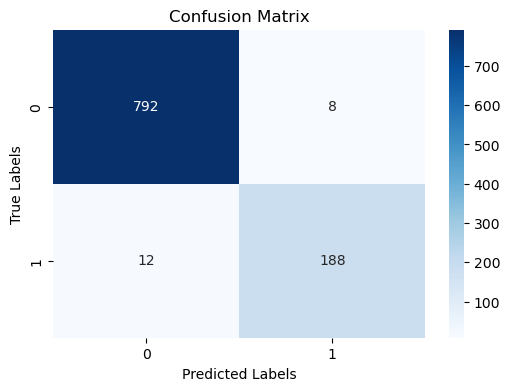


Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.9900    0.9875       800
           1     0.9592    0.9400    0.9495       200

    accuracy                         0.9800      1000
   macro avg     0.9721    0.9650    0.9685      1000
weighted avg     0.9799    0.9800    0.9799      1000



In [874]:
# Confusion Matrix
cm = confusion_matrix(true_labels, entropy_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, entropy_predictions, digits=4))

In [955]:
# confidence testing
confidence_predictions, _ = predict_test_with_smoothing(test_count, confidence_priors_prob, confidence_word_probs)

In [956]:
true_labels = test_df['class'].tolist()
confidence_accuracy = calc_accuracy(confidence_predictions, true_labels)
print("Accuracy:", confidence_accuracy)

correct predict: 975
total test: 1000
Accuracy: 0.975
